In [1]:
import os
import glob
import re
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
from scipy.stats import ttest_ind
from matplotlib.colors import rgb2hex
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, train_test_split
# from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

## Read Data

In [3]:
datafiles = glob.glob(os.path.join(os.getcwd(), 'data_reshape', '*.csv'))
daily_expenses_fp, daily_text_fp, monthly_expenses_fp, diaraists_fp = datafiles

In [4]:
daily = pd.read_csv(daily_expenses_fp)
monthly = pd.read_csv(monthly_expenses_fp)
diarists = pd.read_csv(diaraists_fp)
daily_text = pd.read_csv(daily_text_fp)

In [5]:
diarists = diarists.rename(columns={'index': 'diary_index'})

## Introspect `DataFrames`

In [6]:
diarists.head(3)

diary_index    salary         location  \
0            0   37100.0  Dublin, Ireland   
1            1   85000.0    Las Vegas, NV   
2            2  919216.0        Singapore   

                                                 url  
0  https://www.refinery29.com/money-diary-dublin-...  
1  https://www.refinery29.com/money-diary-las-veg...  
2  https://www.refinery29.com/money-diary-singapo...

In [7]:
daily.head(3)

day_total  day_nm  diary_index
0      95.10       1            0
1       0.00       2            0
2      19.86       3            0

In [8]:
monthly.head(3)

title                              value  diary_index
0  Occupation  Digital Marketing Account Manager            0
1    Industry                        Hospitality            0
2         Age                                 26            0

## Histograms of Salary and Weekly Spend

In [9]:
df = diarists.merge(daily, on='diary_index')
df = df[df.salary > 3000] # Only 2 unemployed diarists, and ~8 old diaries w/o easily parseable salaries. Exclude 22 hourly-paid diarists.
df = df[df.diary_index != 125] # Sex worker diary daily spends are not easily parseable...too bad.
df.columns, df.shape

(Index(['diary_index', 'salary', 'location', 'url', 'day_total', 'day_nm'], dtype='object'),
 (1820, 6))

In [10]:
df['week_total'] = df.groupby('diary_index').day_total.transform(sum)
totals = df.groupby('diary_index')[['diary_index', 'salary', 'week_total', 'location', 'url']].first()

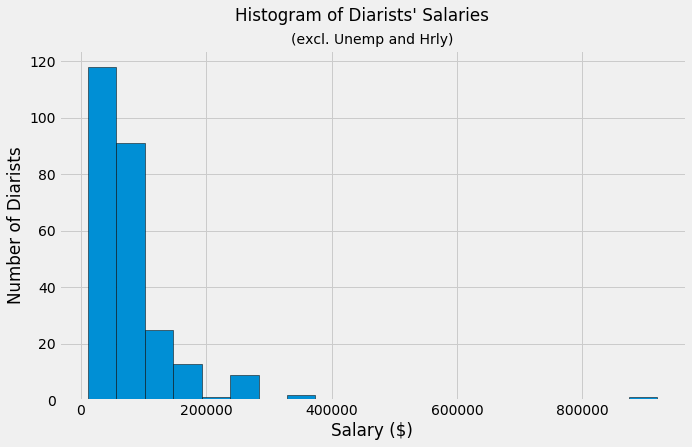

In [11]:
plt.figure(figsize=(10,6))
plt.suptitle("Histogram of Diarists' Salaries")
plt.title("(excl. Unemp and Hrly)", fontsize=14)
plt.xlabel("Salary ($)")
plt.ylabel("Number of Diarists")
totals.salary.hist(bins=20, edgecolor='black');

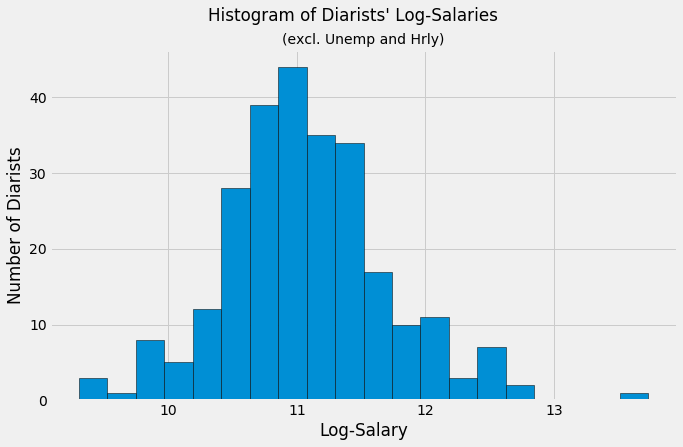

In [12]:
plt.figure(figsize=(10,6))
plt.suptitle("Histogram of Diarists' Log-Salaries")
plt.title("(excl. Unemp and Hrly)", fontsize=14)
plt.xlabel("Log-Salary")
plt.ylabel("Number of Diarists")
totals.salary.apply(np.log).hist(bins=20, edgecolor='black');

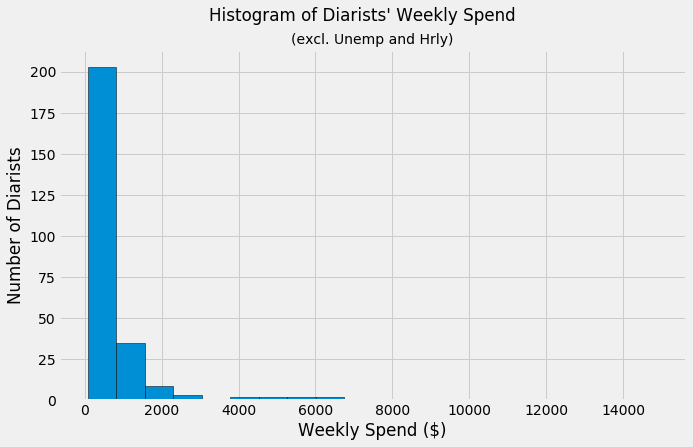

In [13]:
plt.figure(figsize=(10,6))
plt.suptitle("Histogram of Diarists' Weekly Spend")
plt.title("(excl. Unemp and Hrly)", fontsize=14)
plt.xlabel("Weekly Spend ($)")
plt.ylabel("Number of Diarists")
totals.week_total.hist(bins=20, edgecolor='black');

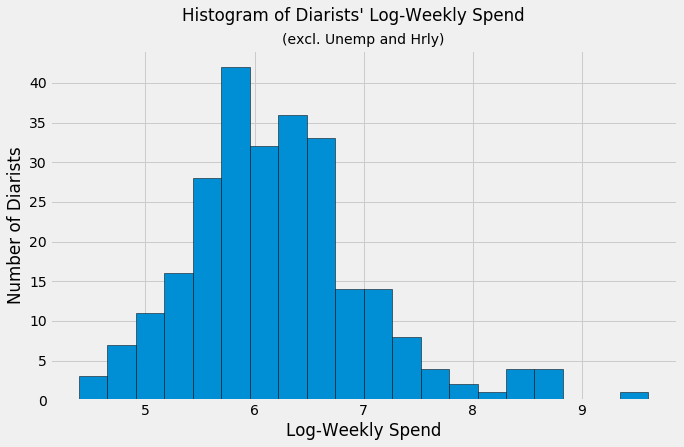

In [14]:
plt.figure(figsize=(10,6))
plt.suptitle("Histogram of Diarists' Log-Weekly Spend")
plt.title("(excl. Unemp and Hrly)", fontsize=14)
plt.xlabel("Log-Weekly Spend")
plt.ylabel("Number of Diarists")
totals.week_total.apply(np.log).hist(bins=20, edgecolor='black');

In [15]:
totals.salary.describe()

count       260.000000
mean      80727.050000
std       76886.320071
min       11000.000000
25%       43375.000000
50%       60000.000000
75%       91979.000000
max      919216.000000
Name: salary, dtype: float64

In [16]:
totals.week_total.describe()

count      260.000000
mean       782.849615
std       1280.385095
min         80.740000
25%        295.760000
50%        459.935000
75%        716.392500
max      14893.700000
Name: week_total, dtype: float64

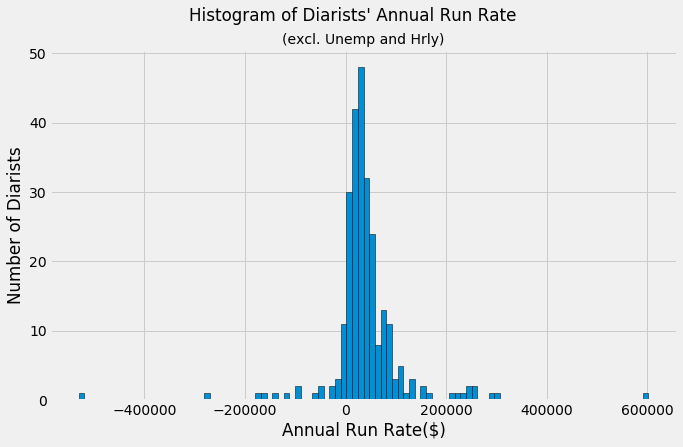

In [17]:
plt.figure(figsize=(10,6))
plt.suptitle("Histogram of Diarists' Annual Run Rate")
plt.title("(excl. Unemp and Hrly)", fontsize=14)
plt.xlabel("Annual Run Rate($)")
plt.ylabel("Number of Diarists")
(totals.salary - 52 * totals.week_total).hist(bins=100, edgecolor='black');

In [18]:
(totals.salary - 52 * totals.week_total).describe()

count       260.000000
mean      40018.870000
std       78869.861221
min     -530472.400000
25%       16062.620000
50%       32355.920000
75%       55127.480000
max      601814.760000
dtype: float64

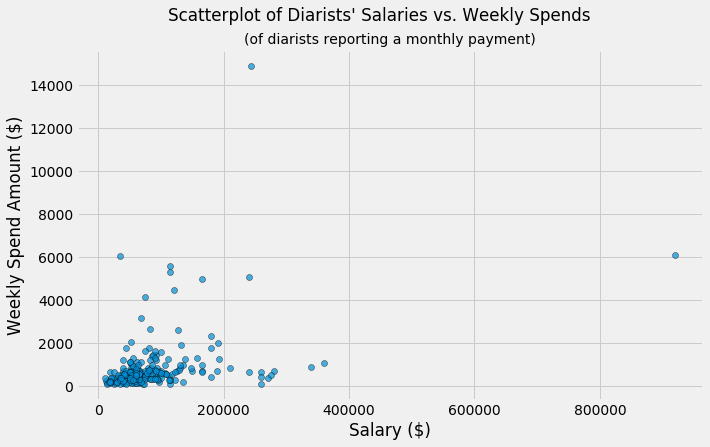

In [19]:
plt.figure(figsize=(10,6))
plt.suptitle("Scatterplot of Diarists' Salaries vs. Weekly Spends")
plt.title("(of diarists reporting a monthly payment)", fontsize=14)
plt.xlabel("Salary ($)")
plt.ylabel("Weekly Spend Amount ($)")
plt.scatter(totals.salary, totals.week_total, edgecolor='black', alpha=0.7);

In [20]:
lr = LinearRegression()
X = np.log(totals.salary).values.reshape(-1, 1)
y = np.log(totals.week_total).values.reshape(-1, 1)
lr.fit(X, y)

r2 = lr.score(X, y)
beta = lr.coef_[0,0]
print("Regression of log-salary on log-weekly spend")
print("R-Squared of Simple Linear Regression model: \t{0:.3f}".format(r2))
print("Coefficient of log-salary: \t\t\t{0:.3f}".format(beta))

Regression of log-salary on log-weekly spend
R-Squared of Simple Linear Regression model: 	0.237
Coefficient of log-salary: 			0.631


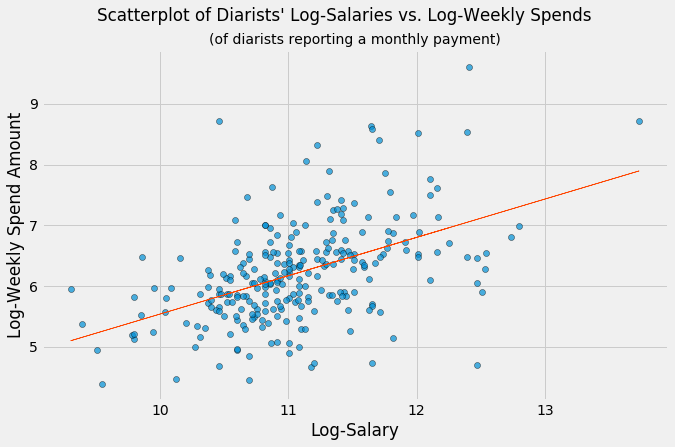

In [21]:
y_hat = lr.predict(np.log(totals.salary).values.reshape(-1, 1))

plt.figure(figsize=(10,6))
plt.suptitle("Scatterplot of Diarists' Log-Salaries vs. Log-Weekly Spends")
plt.title("(of diarists reporting a monthly payment)", fontsize=14)
plt.xlabel("Log-Salary")
plt.ylabel("Log-Weekly Spend Amount")
plt.scatter(np.log(totals.salary), np.log(totals.week_total), edgecolor='black', alpha=0.7)
plt.plot(np.log(totals.salary), y_hat, color='orangered', linewidth=0.7);

## Sankey plot of Salary/Spend Quantiles

Idea for improvement: show salary/spend quantile values as labels on the plot.

In [22]:
# Settings.

QUANTILES = 6
MPL_CMAP = plt.cm.Set2
PLOT_TITLE = "Money Diaries Sankey Quantile Plot"
FLOW_COLOR = '#262C46'
SAVEPATH = 'sankey-plot.html'

In [23]:
# Create a DataFrame of Quantile information.
# Indicates which decile a diarist's salary & weekly spend is.
# 1 represents lowest (100 / n)%; n represents highest (100 / n)%.

salary_quantiles = pd.DataFrame(pd.qcut(totals.salary, QUANTILES, labels=range(1, QUANTILES + 1)))
spend_quantiles = pd.DataFrame(pd.qcut(totals.week_total, QUANTILES, labels=range(1, QUANTILES + 1)))
quantile_df = salary_quantiles.merge(spend_quantiles, left_index=True, right_index=True)
quantile_df.columns = ['salary_quantile', 'weekly_total_quantile']
urls = pd.DataFrame(totals[['diary_index', 'url']])
quantile_df = quantile_df.merge(urls, left_index=True, right_on='diary_index')
quantile_df = quantile_df.drop('diary_index', axis=1)

In [24]:
# sankey_df summarizes the quantile numbers and
# counts in a Plotly-friendly mapping.

sankey_df = quantile_df.groupby(['salary_quantile', 'weekly_total_quantile']).url.count().reset_index()

In [25]:
# Prepare colors and labels for Plotly.

color_list = MPL_CMAP(np.linspace(0, 1, QUANTILES), alpha=0.5)
cmap = [rgb2hex(color_list[q-1]) for q in sankey_df.salary_quantile]
sal_labels = []
spend_labels = []
for i in range(QUANTILES):
    sal_labels.append("Salary Quantile {0:d}".format(i+1))
    spend_labels.append("Spend Quantile {0:d}".format(i+1))
labels = sal_labels + spend_labels

In [26]:
# Generate sankey plot with Plotly.

data = dict(
    type='sankey',
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label = labels,
      color = [FLOW_COLOR] * sankey_df.shape[0]
    ),
    link = dict(
      source = sankey_df.salary_quantile.astype(int) - 1,
      target = sankey_df.weekly_total_quantile.astype(int) + QUANTILES - 1,
      value = sankey_df.url,
      color = cmap
  ))

layout =  dict(
    title = PLOT_TITLE,
    font = dict(
      size = 14
    )
)

fig = dict(data=[data], layout=layout)
# plotly.offline.plot(fig, validate=False, filename=SAVEPATH)

In [27]:
# Delete stored file.
# !rm /Users/davidoxnard/Documents/ds/python_work/misc/money_diaries/sankey-plot.html

## Student Loans

This data needs to be manually cleaned.  Saved to `adhoc_data` directory for cleaning.

Manually write in student loan payments and totals, diarist/spouse, where possible.  Values left null if a values can't be determined.  The saveout is overly-inclusive, so delete rows that are non-student loans.

After cleaning, there are not enough obs for total, remaining student debt to be interesting.  Oh well.

In [28]:
monthly[monthly.title.str.lower().str.contains('student')].title.value_counts()
_ = monthly[monthly.title.str.lower().str.contains('student')].shape[0]
print("Number of monthly expense records containing \"student\": ", _)

Number of monthly expense records containing "student":  160


In [29]:
monthly[monthly.title.str.lower() == 'loan payments'].title.value_counts()
_ = monthly[monthly.title.str.lower() == 'loan payments'].shape[0]
print("Number of monthly expense records containing \"loan payments\": ", _)

Number of monthly expense records containing "loan payments":  64


In [30]:
_1 = monthly[monthly.title.str.lower().str.contains('student')]
_2 = monthly[monthly.title.str.lower() == 'loan payments']
raw_st_loans = pd.concat([_1, _2] ,axis=0)

In [31]:
savepath = 'adhoc_data/student_loans_raw.csv'
# raw_st_loans.to_csv(savepath)

In [32]:
loadpath = 'adhoc_data/student_loans_cleaned.csv'
student_loans = pd.read_csv(loadpath)
student_loans = student_loans.drop('Unnamed: 0', axis=1)

In [33]:
student_loans[student_loans.payment > 0].payment.describe()

count     119.000000
mean      422.977059
std       444.583742
min        40.000000
25%       178.000000
50%       300.000000
75%       466.000000
max      3000.000000
Name: payment, dtype: float64

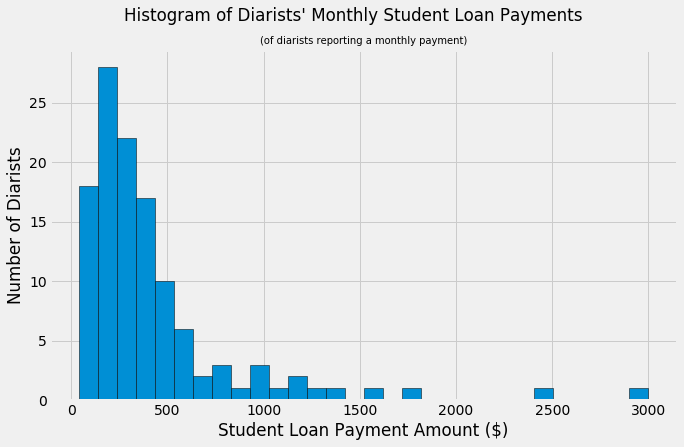

In [34]:
plt.figure(figsize=(10,6))
plt.suptitle("Histogram of Diarists' Monthly Student Loan Payments")
plt.title("(of diarists reporting a monthly payment)", fontsize=14)
plt.xlabel("Student Loan Payment Amount ($)")
plt.ylabel("Number of Diarists")
student_loans[student_loans.payment > 0].payment.hist(bins=30, edgecolor='black');

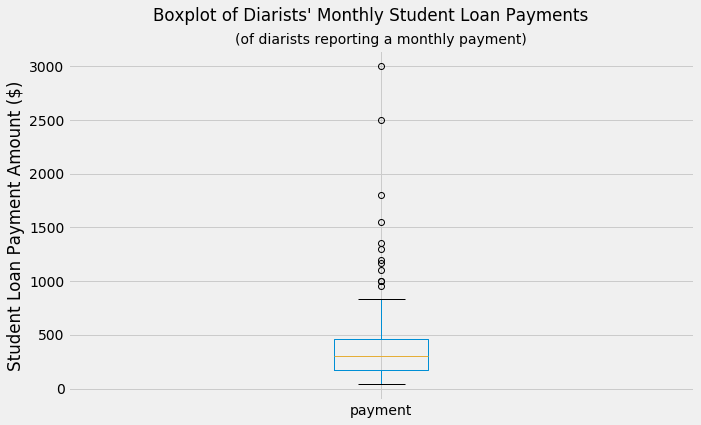

In [35]:
plt.figure(figsize=(10,6))
plt.suptitle("Boxplot of Diarists' Monthly Student Loan Payments")
plt.title("(of diarists reporting a monthly payment)", fontsize=14)
plt.ylabel("Student Loan Payment Amount ($)")
student_loans[student_loans.payment > 0].payment.plot(kind='box');

## Student Loans vs. Salary

In [36]:
SALARY_LOWER_BOUND = 3000 # drop about 10 non-parsed diaries and some unemployment/others.

In [37]:
# Merge `student_loans` with `diarists` to associate payment and salary data.
# Split diarists that reported payments, and those that reported no payments.
# (All other diarists did not report student loans in their diary.)

loans_salary = student_loans.merge(diarists, on='diary_index')[['payment', 'diary_index', 'salary', 'location', 'url']]
loans_salary = loans_salary[loans_salary.salary > SALARY_LOWER_BOUND]
yes_loans = loans_salary[loans_salary.payment > 0]
no_loans = loans_salary[loans_salary.payment == 0]

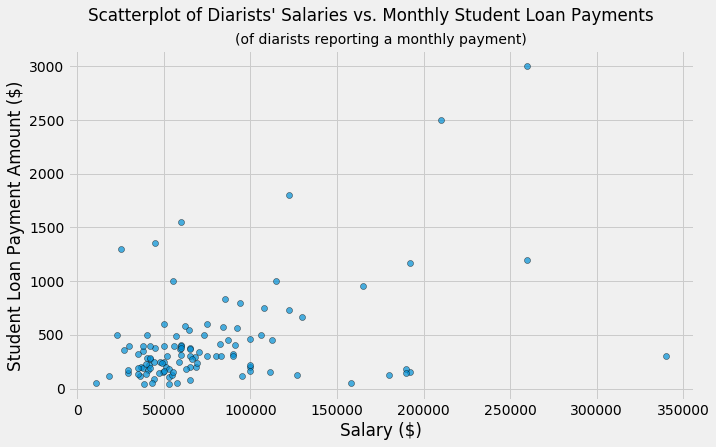

In [38]:
plt.figure(figsize=(10,6))
plt.suptitle("Scatterplot of Diarists' Salaries vs. Monthly Student Loan Payments")
plt.title("(of diarists reporting a monthly payment)", fontsize=14)
plt.xlabel("Salary ($)")
plt.ylabel("Student Loan Payment Amount ($)")
plt.scatter(yes_loans.salary, yes_loans.payment, edgecolor='black', alpha=0.7);

In [39]:
lr = LinearRegression()
X = np.log(yes_loans.salary).values.reshape(-1, 1)
y = np.log(yes_loans.payment).values.reshape(-1, 1)
lr.fit(X, y)

r2 = lr.score(X, y)
beta = lr.coef_[0,0]
print("Regression of log-salary on log-student loan payment")
print("R-Squared of Simple Linear Regression model: \t{0:.3f}".format(r2))
print("Coefficient of log-salary: \t\t\t{0:.3f}".format(beta))

Regression of log-salary on log-student loan payment
R-Squared of Simple Linear Regression model: 	0.113
Coefficient of log-salary: 			0.483


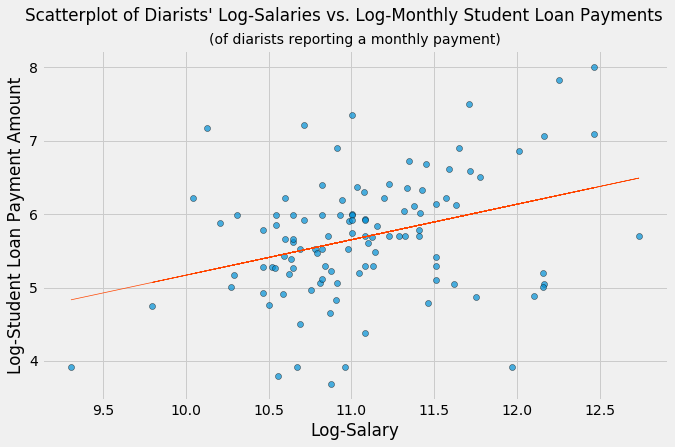

In [155]:
y_hat = lr.predict(np.log(yes_loans.salary).values.reshape(-1, 1))

plt.figure(figsize=(10,6))
plt.suptitle("Scatterplot of Diarists' Log-Salaries vs. Log-Monthly Student Loan Payments")
plt.title("(of diarists reporting a monthly payment)", fontsize=14)
plt.xlabel("Log-Salary")
plt.ylabel("Log-Student Loan Payment Amount")
plt.scatter(np.log(yes_loans.salary), np.log(yes_loans.payment), edgecolor='black', alpha=0.7)
plt.plot(np.log(yes_loans.salary), y_hat, color='orangered', linewidth=0.7);

## Housing

In [41]:
for e in ['rent', 'mortgage', 'house']:
    _ = monthly[monthly.title.str.lower().str.contains(e)].shape[0]
    print("Number of monthly expense records containing \"{0:s}\":    \t".format(e), _)

Number of monthly expense records containing "rent":    	 198
Number of monthly expense records containing "mortgage":    	 36
Number of monthly expense records containing "house":    	 17


Need to do a manual clean of `monthly` before this will really work.

## Daily Text Topic Modeling

`NMF` seems to produce much more interesting results than `LatentDirichletAllocation`.

In [42]:
# Helper function for tokenizing and stemming
def tokenize_stem(txt):
    '''
    Take a string and return a string of stemmed tokens separated by a single space.
    '''
    tokenizer = TreebankWordTokenizer()
    stemmer = SnowballStemmer('english')

    return ' '.join([stemmer.stem(i) for i in tokenizer.tokenize(txt)])

In [43]:
# Split diaries into sentences. Discard timestamps.

sentences = []
time_regex = '[0-1]?[0-9]:?[0-5]?[0-9]?\s[amp.]{4}\s—\s'
end_sentence_regex = '([a-z0-9]{2}\)?\.\s)'

for txt in daily_text.day_rawtext:
    split_times = ' '.join([i.strip() for i in re.split(time_regex, txt) if i])
    fragments = re.split(end_sentence_regex, split_times)
    new_sentences = []
    for i in range(0, len(fragments), 2):
        try:
            new_sentence = fragments[i] + fragments[i+1]
        except IndexError:
            new_sentences.append(fragments[i])
        else:
            new_sentences.append(new_sentence)
    sentences.extend(new_sentences)
print("Number of un-tokenized, unstemmed sentences: {0:d}".format(len(sentences)))

Number of un-tokenized, unstemmed sentences: 42560


In [44]:
NUM_TOPICS = 5
TOP_WORDS = 15
TOPIC_MODEL = NMF

In [45]:
# Old options:
# DOCUMENTS = sentences
# DOCUMENTS = daily_text.day_rawtext

DOCUMENTS = [tokenize_stem(s) for s in sentences]
print("Example document to input into topic models:\n")
print(DOCUMENTS[0])

Example document to input into topic models:

i get to sleep in a bit this morn becaus , although it 's monday , my boyfriend b. and i are in switzerland visit my parent , and our flight back to dublin is n't until later tonight .


### Topic modeling with `CountVectorizer`

In [46]:
cv = CountVectorizer(stop_words='english')
cv_matrix = cv.fit_transform(DOCUMENTS)
names = cv.get_feature_names()

In [47]:
topic_model_cv = TOPIC_MODEL(n_components=NUM_TOPICS, random_state=10)
topic_model_cv.fit(cv_matrix);

In [48]:
for topic_ix, topic in enumerate(topic_model_cv.components_):
    print("Topic {0:d}: ".format(topic_ix+1), ", ".join(names[i] for i in topic.argsort()[:-TOP_WORDS-1:-1]))

Topic 1:  make, coffe, breakfast, dinner, egg, chicken, toast, chees, tea, salad, cup, avocado, fri, butter, milk
Topic 2:  total, daili, 50, 10, bed, 30, 20, 12, 11, 25, watch, 40, asleep, 45, 14
Topic 3:  work, day, leav, today, coffe, readi, head, befor, earli, offic, morn, hour, late, start, project
Topic 4:  home, head, way, walk, stop, befor, dinner, pick, dog, bed, husband, come, boyfriend, drive, groceri
Topic 5:  time, friend, eat, day, lunch, week, becaus, feel, befor, ve, today, dinner, like, meet, want


### Topic modeling with `TfidfVectorizer`

In [49]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(DOCUMENTS)
names = tfidf.get_feature_names()

In [50]:
topic_model_tfidf = TOPIC_MODEL(n_components=NUM_TOPICS, random_state=10)
topic_model_tfidf.fit(tfidf_matrix);

In [51]:
for topic_ix, topic in enumerate(topic_model_tfidf.components_):
    print("Topic {0:d}: ".format(topic_ix+1), ", ".join(names[i] for i in topic.argsort()[:-TOP_WORDS-1:-1]))

Topic 1:  total, daili, 50, 10, 30, 20, 25, 12, 40, 11, 45, 17, 29, 34, 15
Topic 2:  make, eat, lunch, time, coffe, friend, dinner, day, week, feel, breakfast, meet, night, befor, wake
Topic 3:  work, readi, day, leav, today, earli, late, start, head, morn, hour, project, email, arriv, offic
Topic 4:  home, head, bed, walk, befor, way, dog, final, uber, drive, shower, pick, stop, gym, boyfriend
Topic 5:  pay, card, boyfriend, friend, month, sinc, credit, cash, use, venmo, drink, ll, split, park, uber


## Classification of Diary Text

Redo with stemmed, tokenized text

In [52]:
_ = daily_text[daily_text.day_rawtext.str.lower().str.contains('coffee')].shape[0]
print("Number of diariy entries that mention coffee:  {0:d}".format(_))

Number of diariy entries that mention coffee:  1079


In [53]:
_ = daily_text[daily_text.day_rawtext.str.lower().str.contains('coffee')].shape[0] / daily_text.shape[0]
print("Proportion of diariy entries that mention coffee:  {0:.0f}%".format(_ * 100))

Proportion of diariy entries that mention coffee:  53%


In [54]:
# `full_diaries` is a series of text from full (seven days' worth) diaries, indexed by diary_index.

daily_text['day_rawtext'] = daily_text.groupby('diary_index').day_rawtext.apply(lambda x: x.str.rstrip() + " ")
full_diaries_df = pd.DataFrame(daily_text.groupby('diary_index').day_rawtext.apply(lambda x: ','.join(x)))

In [55]:
# `salary_quantiles_df` summarizes which salary quantile a diarist falls into.
# 1 represents lowest (100 / n)%; n represents highest (100 / n)%.

QUANTILES = 2

salary_quantiles_df = pd.DataFrame(pd.qcut(diarists.salary, QUANTILES, labels=range(1, QUANTILES + 1)))

In [56]:
# `qnt_txt_sal` merges the two DataFrames above.

qnt_txt_sal = full_diaries_df.merge(salary_quantiles_df, right_index=True, left_index=True)

In [57]:
qnt_txt_sal.head()

day_rawtext salary
diary_index                                                          
0            9 a.m. — I get to sleep in a bit this morning ...      1
1            9 a.m. — Wake up. Brush my teeth. Re-curl beac...      2
2            4 a.m. — I wake up after seven full hours of s...      2
3            7:20 a.m. — My dog alarm clock wakes me up — h...      2
4            9:20 a.m. — Wake up after snoozing the alarm a...      1

Which words are the most important in fitting a Random Forest Classifier?

In [58]:
NUM_WORDS = 5
FEATURE_REPR = CountVectorizer
CLASSIFIER = RandomForestClassifier

In [59]:
vect = FEATURE_REPR(stop_words='english', ngram_range=(1,2))
clf = CLASSIFIER(n_estimators=1000, random_state=10)

In [60]:
X = vect.fit_transform(qnt_txt_sal.day_rawtext)
y = qnt_txt_sal.salary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [61]:
vocab = vect.get_feature_names()

In [62]:
cross_validate(clf, X_train, y_train, cv=10)

{'fit_time': array([  9.72050405,   8.74400091,   8.73596811,   9.59144688,
          9.08249807,  10.21581793,  10.43876886,  10.30666399,
          9.31564903,  10.85037708]),
 'score_time': array([ 1.3251152 ,  1.29394317,  1.31819797,  1.21243501,  1.60455871,
         1.53355813,  1.38827276,  1.37854099,  1.22623205,  1.25985289]),
 'test_score': array([ 0.45833333,  0.66666667,  0.58333333,  0.79166667,  0.70833333,
         0.65217391,  0.60869565,  0.59090909,  0.63636364,  0.5       ]),
 'train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])}

In [63]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [64]:
accuracy_score(y_test, clf.predict(X_test))

0.66101694915254239

In [65]:
word_importance_ix = np.argsort(clf.feature_importances_)[::-1]
for i in range(NUM_WORDS):
    nth_most_important_word = word_importance_ix[i]
    print(vocab[nth_most_important_word])

husband
30 husband
husband gets
walk
24


How does word usage differ across quantiles?

The cell below shows mean and stddev of the count of the target word in each quantile.

In [77]:
COUNT_SUBSTRING = 'dinner'

_ = qnt_txt_sal.day_rawtext.apply(lambda x: x.count(COUNT_SUBSTRING))
_ = pd.DataFrame(_)
_ = _.rename(columns={'day_rawtext': 'substring_count'})
substr_counts = qnt_txt_sal.merge(_, left_index=True, right_index=True)
substr_counts.groupby('salary').substring_count.mean(), substr_counts.groupby('salary').substring_count.std()

(salary
 1    5.404110
 2    5.889655
 Name: substring_count, dtype: float64, salary
 1    3.170073
 2    3.259851
 Name: substring_count, dtype: float64)

In [67]:
substr_counts[substr_counts.salary == 1].shape[0], substr_counts[substr_counts.salary == 2].shape[0]

(146, 145)

## Difference in Word Counts (two-sample t-test)

In [68]:
# Settings.

GROUP_SIZE = 28*2          # Pick the top N and bottom N diarists w.r.t. salary. (28 is ~10% of diarists)
PVAL_THRESHOLD = 0.00005   # Threshold for the t-test.
IGNORE_LOW_SAL = True      # Ignore the ~20 low-salaried diarists in the bottom group? (unemp + poorly parsed)
INCLDUE_STOPWORDS = True   # Use sklearn's stopwords list in the CountVectorizer?

In [69]:
# Helper function for tokenizing and stemming

def tokenize_stem(txt):
    '''
    Take a string and return a string of stemmed tokens separated by a single space.
    '''
    tokenizer = TreebankWordTokenizer()
    stemmer = SnowballStemmer('english')

    return ' '.join([stemmer.stem(i) for i in tokenizer.tokenize(txt)])

In [70]:
# Prepare DataFrames.

fulltext_salary = full_diaries_df.merge(diarists, left_index = True,
                                        right_on='diary_index')[['salary', 'day_rawtext', 'url']]
if IGNORE_LOW_SAL:
    fulltext_salary = fulltext_salary[fulltext_salary.salary > 3000] # magic number: unemp + poorly parsed salaries.

_ = fulltext_salary.sort_values(by='salary', ascending=False)
n = _.shape[0]
top_n = _[:GROUP_SIZE]
bottom_n = _[n - GROUP_SIZE:]

In [71]:
# Tokenize, stem, and prepare (sparse) matrices of token counts.

stops = 'english' if INCLDUE_STOPWORDS else None

tokenized_stemmed_text = fulltext_salary.day_rawtext.apply(lambda x: tokenize_stem(x))

vect = CountVectorizer(stop_words=stops, tokenizer=lambda x: x.split())
_ = vect.fit(tokenized_stemmed_text)
vocab = vect.get_feature_names()
print("Number of 1-grams in the vocab: {0:d}".format(len(vocab)))

top_n_matrix = vect.transform(top_n.day_rawtext)
bottom_n_matrix = vect.transform(bottom_n.day_rawtext)

Number of 1-grams in the vocab: 23009


In [75]:
# Execute two-sample t-test and print results.

print("Two-sample t-tests to detect words that the top N and bottom N diaraists use with different frequency:\n")
for i, word in enumerate(vocab):
    
    top = top_n_matrix[:,i].todense()
    bottom = bottom_n_matrix[:,i].todense()
    
    p = ttest_ind(top, bottom).pvalue[0]
    if p < PVAL_THRESHOLD:
        xbar_top = round(top.mean(), 2)
        xbar_bottom = round(bottom.mean(), 2)       
        print("WORD:", word, "\tPVAL:", round(p, 7), "\tXBAR_TOP  :", xbar_top,
              "\tXBAR_BOTTOM:", xbar_bottom, "\tDIST:", round(xbar_top - xbar_bottom, 2),
              "\tINDEX:", i)

Two-sample t-tests to detect words that the top N and bottom N diaraists use with different frequency:

WORD: husband 	PVAL: 1.16e-05 	XBAR_TOP  : 8.07 	XBAR_BOTTOM: 0.89 	DIST: 7.18 	INDEX: 12121


## Write `monthly` to disk for manual cleaning

In [159]:
savepath = 'adhoc_data/monthly_expenses_raw.csv'
_ = monthly[['diary_index', 'title', 'value']]
# _.to_csv(savepath)